# 深層学習と画像認識

画像データ（手書きの文字）を用いて、画像認識に挑戦してみます。
原理を理解すれば、より複雑な画像認識にも応用することができるようになります。

![imagenet-fs8.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/57754/1296178f-4bfd-e03b-2120-4b5278bf5df1.png)

[ImageNet](https://devopedia.org/imagenet)より引用

__おなじみのモジュールの準備__


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import japanize_matplotlib #matplotlibの日本語化  
except ModuleNotFoundError:
    !pip install japanize_matplotlib
    import japanize_matplotlib 
sns.set(font="IPAexGothic") #日本語フォント設定


## MNIST

MNIST は、「0」~「9」の手書き数字の画像データセットです。Yann LeCun らによって、手書き 文字データセットの NIST データベースから抽出&加工して、機械学習のチュートリアル用に作成されて公開されています。

ここは、画像データ(手書きの文字)を説明変数 (X)、ラベルを目的変数 (y) として学習モデルを作成してみます。

![mnist-fs8.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/57754/d7283850-3cdd-3701-4f56-f7b4ae8090e3.png)


__MNISTデータのロード__

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')


画像データは、`mnist.data`に70000万件、要素数768(28x28)のNumPy配列で登録されています。画像データのラベルは、`mnist.target`に70000件登録されています。

__画像データとラベルデータの大きさ__

In [13]:
print('画像データ', mnist.data.shape)
print('ラベル', mnist.target.shape)

画像データ (70000, 784)
ラベル (70000,)


最初の画像データをみてみましょう。
784要素の配列はみにくいので、28x28で表示してみます。
0~255 階調のグレースケールになっています。

In [14]:
print(mnist.data.values[0])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

<div class="alert alert-warning">

データ形式

sklearnのバージョンによっては、mnist.dataの形式が異なるようです。
アクティブに開発が進んでいるライブラリには、こういうことはよくあります。

__落ち着いてデータの形式を調べて対処してください__
```
print(mnist.data)
```

エラーが発生した場合は、`data.values[0]`の代わりに、
次のように`data[0]`のように`.values`を取り除いてください。
</div>

Matplotlibで表示することもできます。0が黒で白が255なので、文字が白くなります。

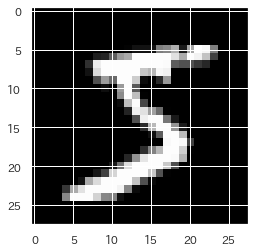

In [17]:
plt.imshow(mnist.data.values[0].reshape(28,28), cmap=plt.cm.gray)

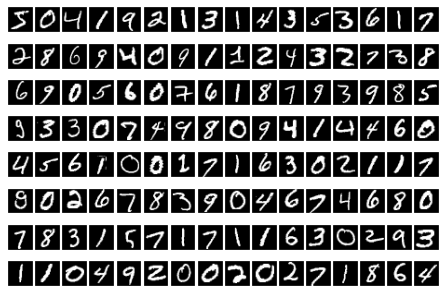

In [20]:
W = 16 # 横に並べる個数
H = 8 # 縦に並べる個数
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)
for i in range(W*H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(mnist.data.values[i].reshape((28, 28)), cmap=plt.cm.gray)
plt.show()

機械学習では、28x28 Grayscale の画像データを784次元のデータとして扱います。
まず、0〜255のグレースケールの値を0.0〜1.0の範囲に正規化しておきます。
ホールドアウト法を用いて、訓練データとテストデータに分割しておきます。


In [21]:
X = mnist.data.values.reshape(70000, 784) / 255  # [0,1]で正規化
y = mnist.target.values.astype(int)

# 訓練データとテストデータ
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=0)

print('訓練データ数:', len(X_train))
print('テストデータ数:', len(X_test))


訓練データ数: 60000
テストデータ数: 10000


### 画像データの分布

（少しお遊びで）２次元に次元圧縮して、手書き文字がどのように分布しているかみてみましょう。

__1000枚だけ選んでPCAで次元圧縮__

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X[:1000])  # 1000枚選ぶ
pc12 = pca.transform(X[:1000])

__表データに変換__

In [23]:
data = pd.concat([pd.DataFrame(pc12, columns=['pc1', 'pc2']), pd.DataFrame(y[:1000], columns=['label'])], axis=1)
data.head()


,pc1,pc2,label
0,0.796539,1.323788,5
1,4.334015,1.669418,0
2,0.040727,-1.636907,4
3,-3.972168,2.561420,1
4,-1.316914,-2.598637,9


<Figure size 1080x1080 with 0 Axes>

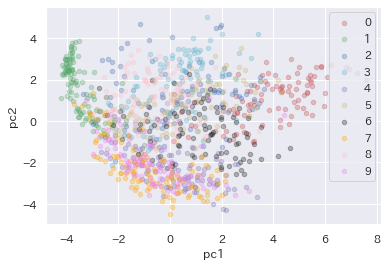

In [25]:
colors =  ["r", "g", "b", "c", "m", "y", "k", "orange", "pink", 'violet']
plt.figure(figsize=(15,15))
ax = None
for i, df in enumerate(data.head(3000).groupby('label')):
  ax = df[1].plot(kind='scatter', x='pc1', y='pc2', alpha=0.3, c=colors[int(i)], label=df[0], ax=ax)
plt.legend()
plt.show()

結構、ごちゃごちゃに重なっているところがあります。綺麗に分類できるのでしょうか？

## 多層パーセプトロン

ニューラルネットワークで紹介した多層パーセプトロン(MLPClassifier)を使ってみます。

MLPClassifier は、パーセプトロンで説明したとおり、豊富なオプションがあります。

__hidden_layer_sizes__: 中間層のサイズを設定します。

中間層が 3 つ (各中間層のニューロン数が 100 個、200 個、100 個) の 5 層ニューラル ネットワークを設定したいときは、次のように設定します。

```
hidden_layer_sizes=(100, 200, 100)
```
__activation__: 中間層の活性化関数

* identity:恒等関数
* logistic:シグモイド関数
* tanh:双曲線正接関数
* relu:ランプ関数

__solver__: 重みの最適化手法

* lbfgs:準ニュートン法に属す BFGS の一種
* sgd:確率的勾配降下法
* adam:確率的勾配降下法にモーメントをつける

__max_iter__: エポック数

今回は、３層パーセプトロンで、前回ならったとおり、活性化関数はシグモイド関数、最適化は確率的勾配降下法を用いてみます。


In [27]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(128,), activation='logistic', solver='sgd', max_iter=20, verbose=10, random_state=0)

訓練データを学習させます。

In [28]:
history = model.fit(X_train, y_train)

Iteration 1, loss = 2.23320721
Iteration 2, loss = 2.06989000
Iteration 3, loss = 1.87448221
Iteration 4, loss = 1.65146930
Iteration 5, loss = 1.43223928
Iteration 6, loss = 1.24331458
Iteration 7, loss = 1.09217506
Iteration 8, loss = 0.97428410
Iteration 9, loss = 0.88245881
Iteration 10, loss = 0.80984222
Iteration 11, loss = 0.75156470
Iteration 12, loss = 0.70398038
Iteration 13, loss = 0.66461657
Iteration 14, loss = 0.63140618
Iteration 15, loss = 0.60303138
Iteration 16, loss = 0.57851333
Iteration 17, loss = 0.55715012
Iteration 18, loss = 0.53832779
Iteration 19, loss = 0.52163356
Iteration 20, loss = 0.50675142
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


<div class="alert alert-info">

ConvergenceWarning：収束が不十分

epoch数が足りないので、収束が不十分だと言われます。
</div>

`history`は学習の様子を記録したログデータです。
損失 (loss) が減少しているときは、順調に学習が進んでいます。

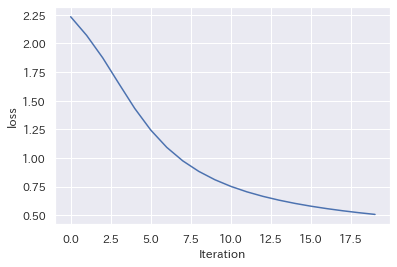

In [29]:
plt.plot(history.loss_curve_)
plt.xlabel('Iteration') 
plt.ylabel('loss') 
plt.grid(True)

In [30]:
y_pred = model.predict(X_test)

[0 4 1 2 4 4 7 1 1 7]


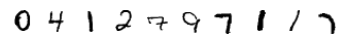

In [31]:
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)

def plot_mnist(X, y):
    fig = plt.figure()
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(X[i].reshape((28, 28)), cmap=plt.cm.gray_r) #白黒反転
    print(y[:10])
    plt.show()

plot_mnist(X_test, y_pred)

### 正解率

In [32]:
print('正解率(train)', model.score(X_train, y_train))
print('正解率(test)', model.score(X_test, y_test))


正解率(train) 0.8761166666666667
正解率(test) 0.8715


ひと昔前は、ハガキの郵便番号を読み取って、自動的に仕分けする装置であっても、
70%の正確さも出ませんでした。それに比べると、素晴らしい正解率です。

<div class="alert alert-info">

Let's try

MLPClassfierのパラメータを変更して、正解率がどう変わるか調べてみよう。

__最近のニューラルネットワークの定番パラメータ__

- 隠れ層を増やす
- 活性化関数: `relu`
- 最適化: `adam`

</div>

<div class="alert alert-info">

PyTorch, TensorFlow, Kelas

深層学習技術は、近年、高度化してきています。
より細かくネットワークの構成やパラメータを設定できる
PyTorch, Tensorflow, Kelas,  などのニューラルネットワーク・ライブラリが登場しています。

__PyTorchによるモデル構築の例__
```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

興味のある人は、
PytorchやTensorflowなどニューラルネットワークを構築してみてください。
より高い正解度のモデルを構築することができます。
（なお、研究レベルの予測モデルを使るときは、
このようなニューラルネットワークフレームワークを活用することになります。）

</div>

## 自分の手書き文字を認識する

最後に、自分自身で書いた手書き文字を認識してみましょう。

紙を用意して数字を書いて、スマホで撮影します。
１文字だけ適当に切り出して、ファイルに保存してみてください。

### Pillow/PIL ライブラリ

画像は、(２年生後期の授業で使った）Pillow/PIL ライブラリを用いて操作します。
まずColab上で自分のファイル（例.`2.png`）を読み込めるか、表示して確認しておきます。


サイズ (324, 318)


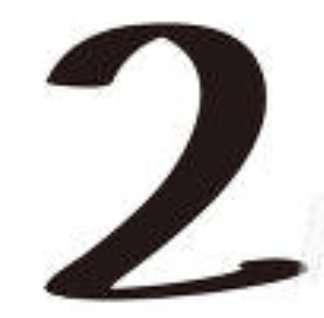

In [4]:
from PIL import Image
im = Image.open("2.png")
print('サイズ', im.size)
im

MNIST用のモデルの画像ファイルは、
グレースケールの28x28なので、Pillow/PIL ライブラリを用いて変換します。

In [8]:
im = Image.open("2.png").convert('L').resize((28,28))
print('サイズ', im.size)
im


サイズ (28, 28)


このPillow画像データをNumPy配列に変換し、784次元のデータにします。

In [40]:
myimage = np.array(im).reshape(1,-1)
myimage.shape

(1, 784)

MNISTのモデルは、白黒が反転している画像で学習しているため、白黒を反転させて、0.0〜1.0に正規化します。これで入力データはできました。

In [41]:
myimage = (255 - myimage)/255

それでは、学習済みのモデルを使って予測してみましょう。正しく予想できるかな？

In [42]:
model.predict(myimage)

array([2])

### アプリケーションへの組み込み

人工知能アプリケーションに学習済みモデルを組み込むときは、毎回学習しなくて済むように学習済みモデルだけ、pickle形式のファイルに保存しておきます。

<div class="alert alert-info">

pickle

Pythonでのオブジェクトをシリアライズする一般的な方法です。**シリアライズ（直列化）**とは、プログラミング言語においてオブジェクトをバイト列のデータに表現に変換することです。逆に、**デシリアライズ（非直列化）**とは、シリアライズしたバイト列から元のオブジェクトに復元することです。

</div>

__モデルの保存__

In [43]:
import pickle
with open('mnist-model.pickle', mode='wb') as fp:
    pickle.dump(model, fp)

保存されたファイルの大きさは1.6Mバイト程度になります。
（もちろん、学習したデータやパラメータにもよります。）

In [46]:
!ls -l mnist-model.pickle

-rw-r--r--  1 kimio  staff  1633114 Mar 22 00:57 mnist-model.pickle


__モデルのロード__

In [44]:
import pickle
with open('mnist-model.pickle', mode='rb') as fp:
    model = pickle.load(fp)
model.predict(myimage)

array([2])

## コースワーク

<div class="admonition tip">

**演習（画像処理）**

[Fashin-MNIST](https://github.com/zalandoresearch/fashion-mnist)の画像データを使って、
ファッションアイテムの分類をしてみよう。

![fashionmnist-fs8.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/57754/6de529e7-2652-4429-8b34-a662b61236b8.png)

</div>


__データの入手方法__
```
from sklearn.datasets import fetch_openml
fashion_mnist = fetch_openml('Fashion-MNIST')
```